In [1]:
import xsimlab as xs
import xarray as xr
from episimlab.models import ExampleSIR, EpiModel
from episimlab.foi import BaseFOI
from episimlab.utils import visualize_compt_graph, coerce_to_da
import networkx as nx
import pandas as pd

# Episimlab Tutorial
----

This notebook will provide a tutorial in model building using Episimlab version 2. For more details, please refer to the [Episimlab GitHub repository](https://github.com/eho-tacc/episimlab) and the [xarray-simlab documentation](https://xarray-simlab.readthedocs.io).

## Installation

To install Episimlab, issue from the command line:
```bash
pip install episimlab
```

...or install the development version from the GitHub repo:
```bash
pip install git+https://github.com/eho-tacc/episimlab
```

## Run an Existing SIR Model
----

The package includes several pre-built models as examples/starting points. Here, we show how to load and run the `ExampleSIR` model:

In [2]:
model = ExampleSIR()
model

<xsimlab.Model (9 processes, 4 inputs)>
setup_seed
    seed_entropy     [in]
setup_compt_graph
setup_sto
    sto_toggle       [in]
setup_coords
setup_state
setup_phi
rate_S2I
    beta             [in]
rate_I2R
    gamma            [in]
compt_model

These pre-packaged models come with a set of default parameter values. New models should include a full set of default parameters so that users can quickly and easily use the same model (say, in a publication):

In [3]:
model.RUNNER_DEFAULTS['input_vars']

{'sto_toggle': 0, 'seed_entropy': 12345, 'beta': 0.08, 'gamma': 0.5}

Of course, we can overwrite the defaults, such as the `beta` value here, and run the model:

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


<xarray.Dataset>
Dimensions:                   (age: 5, compt: 3, step: 15, vertex: 4, risk: 2)
Coordinates:
  * age                       (age) object '0-4' '5-17' '18-49' '50-64' '65+'
  * compt                     (compt) object 'S' 'I' 'R'
  * risk                      (risk) object 'low' 'high'
  * step                      (step) datetime64[ns] 2020-03-01 ... 2020-03-15
  * vertex                    (vertex) object 'Austin' 'Houston' ... 'Dallas'
Data variables:
    compt_model__state        (step, vertex, compt, age, risk) float64 200.0 ...
    rate_I2R__gamma           float64 0.5
    rate_S2I__beta            float64 0.07
    setup_seed__seed_entropy  int64 12345
    setup_sto__sto_toggle     int64 0

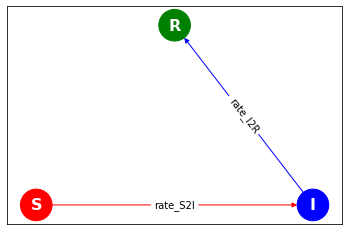

In [4]:
input_vars = {
    'beta': 0.07,
}
model.run(input_vars=input_vars)

The model output is an `xarray.Dataset`, which is very similar to an N-dimensional numpy array. We can also see the compartment graph generated when the model was run. The compartment graph shows allowed transitions in the model. Here, we see that S -> I (`rate_S2I`) and I -> R (`rate_I2R`) transitions are allowed.

We can plot the state of the simulation over time:

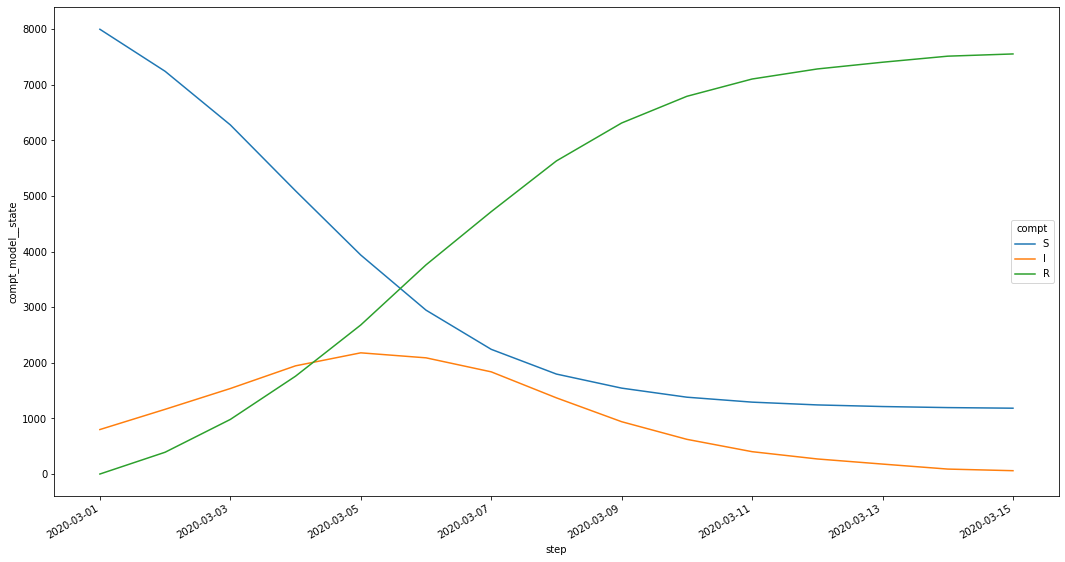

In [5]:
model.plot()

## Modify an Existing Model: Adding a Vaccination Compartment
----

We now want to add more heterogeneity into our model. We will demonstrate this by adding a Vaccinated (`V`) compartment to the model.

Episimlab models are highly modular, so we can easily reuse our existing `ExampleSIR` model instead of writing the new model from scratch. To do this, we will write a few new processes and add them to our existing model:
1. A new process `CustomSetupComptGraph` that generates a compartment graph containing a new `V` node, with new directed edges `(S, V)` and `(V, I)`
2. A new process `RateS2V` that calculates an edge weight `rate_S2V`
3. A new process `RateV2I` that calculates an edge weight `rate_V2I`

### #1: Add a `V` Compartment

To add our "vaccinated" compartment, we need to write a new process `CustomSetupComptGraph` as described above. A "process" is just a Python class with some special features:
- Methods named `initialize`, `run_step`, `finalize_step`, and `finalize` are run automatically at different points in the simulation.
- Variables defined near the beginning of the process can be imported to exported to other processes in the model. In this case, we're exporting the variable `compt_model`.

In [6]:
@xs.process
class CustomSetupComptGraph:
    """A single process in the model. Defines the directed graph `compt_graph`
    that defines the compartments and allowed transitions between them.
    """
    # Reference a variable defined in a different process, and tell the model
    # that this process intends to output this variable.
    compt_graph = xs.global_ref('compt_graph', intent='out')

    def initialize(self):
        """This method is run once at the beginning of the simulation."""
        self.compt_graph = self.get_compt_graph()
    
    def run_step(self):
        """This method is run once at every step of the simulation."""
        pass

    def finalize(self):
        """This method is run once at the end of the simulation."""
        self.visualize()

    def get_compt_graph(self) -> nx.DiGraph:
        """A method that returns a compartment graph as a directed
        graph. Uses the networkx package.
        """
        g = nx.DiGraph()
        g.add_nodes_from([
            ('S', {"color": "red"}),
            ('I', {"color": "blue"}),
            ('R', {"color": "green"}),
            ('V', {"color": "purple"}), # new
        ])
        g.add_edges_from([
            ('S', 'V', {"priority": 0, "color": "purple"}), # new
            ('S', 'I', {"priority": 0, "color": "red"}),
            ('V', 'I', {"priority": 1, "color": "pink"}), # new
            ('I', 'R', {"priority": 2, "color": "blue"}),
        ])
        return g
    
    def visualize(self):
        """Visualize the compartment graph, saving as a file at a path."""
        return visualize_compt_graph(self.compt_graph)

Now that we've written our new process, let's add it to our model:

In [7]:
model.setup_compt_graph

<SetupComptGraph 'setup_compt_graph' (xsimlab process)>
Variables:
    compt_graph    [out] ---> compt_model.compt_graph
Simulation stages:
    initialize
    finalize

In [8]:
sirv_model = model.update_processes({
    'setup_compt_graph': CustomSetupComptGraph
})
sirv_model.setup_compt_graph

<CustomSetupComptGraph 'setup_compt_graph' (xsimlab process)>
Variables:
    compt_graph    [out] ---> compt_model.compt_graph
Simulation stages:
    initialize
    run_step
    finalize

Let's try running our model with the new compartment graph:

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


<xarray.Dataset>
Dimensions:                   (age: 5, compt: 4, step: 15, vertex: 4, risk: 2)
Coordinates:
  * age                       (age) object '0-4' '5-17' '18-49' '50-64' '65+'
  * compt                     (compt) object 'S' 'I' 'R' 'V'
  * risk                      (risk) object 'low' 'high'
  * step                      (step) datetime64[ns] 2020-03-01 ... 2020-03-15
  * vertex                    (vertex) object 'Austin' 'Houston' ... 'Dallas'
Data variables:
    compt_model__state        (step, vertex, compt, age, risk) float64 200.0 ...
    rate_I2R__gamma           float64 0.5
    rate_S2I__beta            float64 0.07
    setup_seed__seed_entropy  int64 12345
    setup_sto__sto_toggle     int64 0

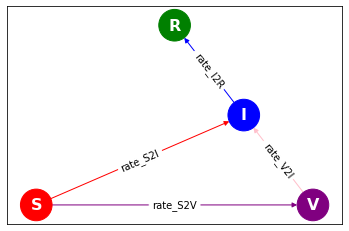

In [9]:
sirv_model.run()

The new model runs, and we get an informative warning at every step. We have defined a new compartment `V` and defined its edges to other departments, but the model still doesn't know what the **weight** of these edges are.

### #2: Calculate `rate_S2V`

To fix the warning, we need only write a new process that calculates and exports edge weights for the S -> V and V -> I transitions that we defined. Let's start by calculating the edge weight of S -> V, which by convention is named `rate_S2V`. 

In [10]:
@xs.process
class RateS2V:
    """A single process in the model. Calculates a vaccination rate
    `rate_S2V`.
    """
    # Define a variable that will be imported from other processes,
    # and tell the model that this process intends to import the variable.
    vacc_per_day = xs.variable(global_name='vacc_per_day', intent='in')
    
    # Define a variable that we want to export
    # We include the `groups=['tm']` in order for the model to recognize
    # this variable as an edge weight.
    rate_S2V = xs.variable(global_name='rate_S2V', groups=['tm'], intent='out')
    
    def initialize(self):
        """If the vaccination rate were constant, we need only need to set
        it once at the beginning of the simulation. Since we want the rate
        to change at a given time, we instead define it in the `run_step`
        method below.
        """
        pass
    
    @xs.runtime(args=['step'])
    def run_step(self, step):
        """Calculate the `rate_S2V` at every step of the simulation.
        Set the rate to zero after the 5th step.
        """
        if step > 5:
            self.rate_S2V = 0.
        else:
            self.rate_S2V = self.vacc_per_day

### #3 Calculate `rate_V2I`

Similarly, let's write a process that defines a `rate_V2I`. This rate will be calculated similarly to force of infection (FOI), so we will **inherit** the existing process `BaseFOI` and modify it in the **child** class `RateV2I`. The `BaseFOI` process has methods like `foi` that we can reuse in the child process.

In [11]:
@xs.process
class RateV2I(BaseFOI):
    """A single process in the model. Calculates a force of infection
    for vaccinated persons `rate_V2I`. This process inherits from the
    parent class BaseFOI.
    """
    # Override the default behavior: calculate FOI based on the population
    # of the V compartment, instead of the S compartment
    S_COMPT_LABELS = 'V'
    
    # Like before, we define a variable that we export in this process
    rate_V2I = xs.variable(dims=('age', 'risk', 'vertex'), 
                           global_name='rate_V2I', groups=['tm'], 
                           intent='out')
    
    # We also define an input variable that scales FOI
    vacc_efficacy = xs.variable(global_name='vacc_efficacy', intent='in')
    
    phi = xs.global_ref('phi', intent='in')
    
    def run_step(self):
        """Calculate the `rate_V2I` at every step of the simulation. Here,
        we make use of the `foi` method in the parent process BaseFOI.
        """
        self.rate_V2I = self.foi * (1 - self.vacc_efficacy)

Finally, add both processes to the model. 

In [12]:
sirv_model = sirv_model.update_processes({
    'setup_compt_graph': CustomSetupComptGraph,
    'rate_S2V': RateS2V,
    'rate_V2I': RateV2I
})

We visualize the processes in the model as a graph:

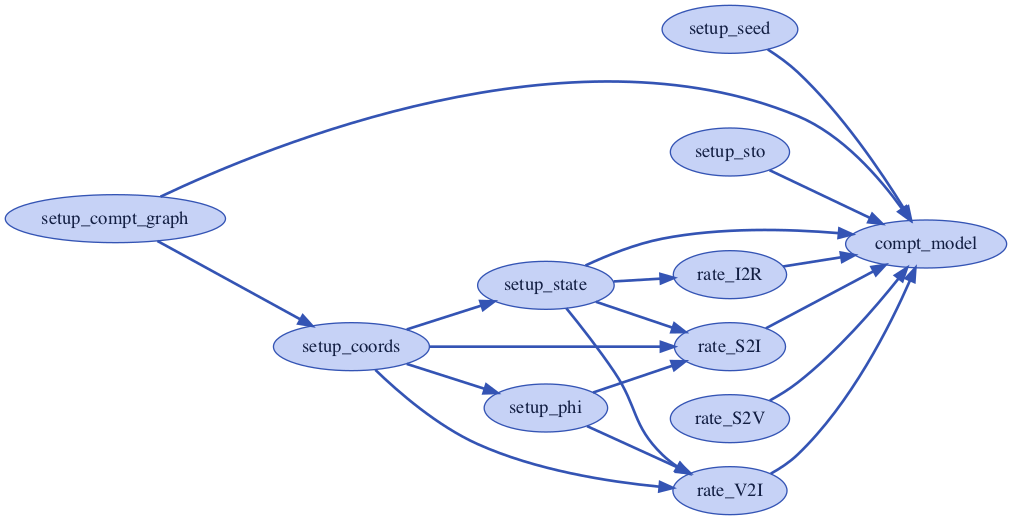

In [13]:
sirv_model.visualize()

We can now run our model, inspect the compartment graph, and plot the results:

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


<xarray.Dataset>
Dimensions:                   (age: 5, compt: 4, step: 15, vertex: 4, risk: 2)
Coordinates:
  * age                       (age) object '0-4' '5-17' '18-49' '50-64' '65+'
  * compt                     (compt) object 'S' 'I' 'R' 'V'
  * risk                      (risk) object 'low' 'high'
  * step                      (step) datetime64[ns] 2020-03-01 ... 2020-03-15
  * vertex                    (vertex) object 'Austin' 'Houston' ... 'Dallas'
Data variables:
    compt_model__state        (step, vertex, compt, age, risk) float64 200.0 ...
    rate_I2R__gamma           float64 0.5
    rate_S2I__beta            float64 0.07
    rate_S2V__vacc_per_day    int64 10
    rate_V2I__beta            float64 0.07
    rate_V2I__vacc_efficacy   float64 0.9
    setup_seed__seed_entropy  int64 12345
    setup_sto__sto_toggle     int64 0

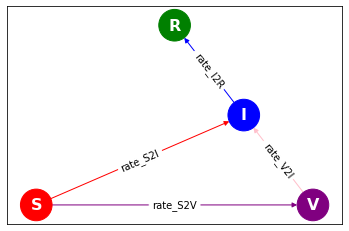

In [14]:
sirv_model.run(
    input_vars={
        'vacc_efficacy': 0.9,
        'vacc_per_day': 10,
        'sto_toggle': 0,
    })

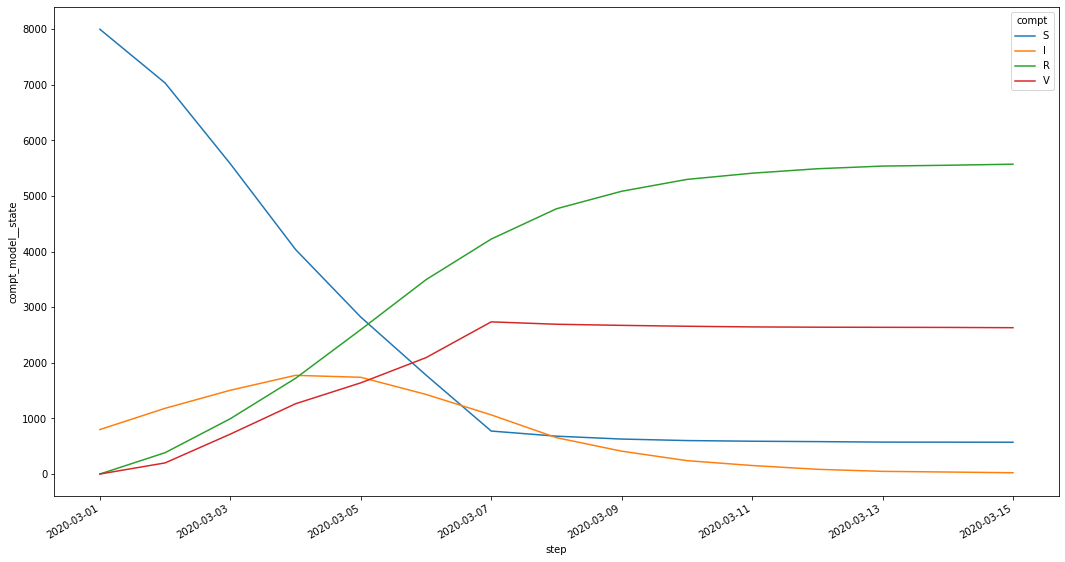

In [15]:
sirv_model.plot()

## Vaccinate Differently by Age
----

Episimlab allows users to set arbitrary dimensions for parameters. We could add age heterogeneity for the `vacc_per_day` variable by modifying our existing processes:

In [16]:
@xs.process
class AgeScaledRateS2V:
    """A single process in the model. Calculates a vaccination rate
    `rate_S2V`. Ingests a `vacc_per_day` with one dimension on `age`.
    """
    vacc_per_day = xs.variable(global_name='vacc_per_day', intent='in',
                               dims=('age')) # new
    rate_S2V = xs.variable(global_name='rate_S2V', groups=['tm'], intent='out')
    
    @xs.runtime(args=['step'])
    def run_step(self, step):
        """Calculate the `rate_S2V` at every step of the simulation.
        Set the rate to zero after step 5.
        """
        if step > 5:
            self.rate_S2V = 0.
        else:
            self.rate_S2V = xr.DataArray(data=self.vacc_per_day, dims=['age']) # new

In [17]:
age_model = sirv_model.update_processes({
    'rate_S2V': AgeScaledRateS2V,
})

In [18]:
age_model

<xsimlab.Model (11 processes, 7 inputs)>
setup_seed
    seed_entropy      [in]
setup_compt_graph
setup_sto
    sto_toggle        [in]
setup_coords
setup_state
setup_phi
rate_S2I
    beta              [in]
rate_I2R
    gamma             [in]
rate_S2V
    vacc_per_day      [in] ('age',) 
rate_V2I
    beta              [in]
    vacc_efficacy     [in]
compt_model

We run the model as usual. Note that we can specify a dictionary of output variables if we want additional data in the output array. In addition to the `state` variable from `compt_model` process, we also want to retrieve the `rate_V2I` variable from the `rate_V2I` process for one of our analyses.

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


<xarray.Dataset>
Dimensions:                   (age: 5, compt: 4, step: 15, vertex: 4, risk: 2)
Coordinates:
  * age                       (age) object '0-4' '5-17' '18-49' '50-64' '65+'
  * compt                     (compt) object 'S' 'I' 'R' 'V'
  * risk                      (risk) object 'low' 'high'
  * step                      (step) datetime64[ns] 2020-03-01 ... 2020-03-15
  * vertex                    (vertex) object 'Austin' 'Houston' ... 'Dallas'
Data variables:
    compt_model__state        (step, vertex, compt, age, risk) float64 200.0 ...
    rate_I2R__gamma           float64 0.5
    rate_S2I__beta            float64 0.07
    rate_S2V__vacc_per_day    (age) int64 0 0 5 10 10
    rate_V2I__beta            float64 0.07
    rate_V2I__rate_V2I        (step, age, risk, vertex) float64 0.0 ... 0.05387
    rate_V2I__vacc_efficacy   float64 0.9
    setup_seed__seed_entropy  int64 12345
    setup_sto__sto_toggle     int64 0

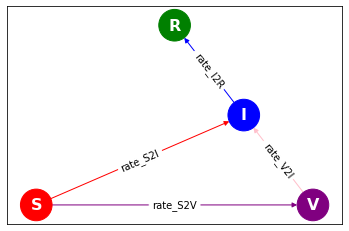

In [19]:
age_model.run(
    input_vars={
        'vacc_efficacy': 0.9,
        # Now stratified by age group:
        # ['0-4', '5-17', '18-49', '50-64', '65+']
        'vacc_per_day': [0, 0, 5, 10, 10] # new
    },
    output_vars={
        # `state` of the `compt_model` over time (`step`)
        'compt_model__state': 'step',
        # `rate_V2I` over time (`step`)
        'rate_V2I__rate_V2I': 'step' # new
    })

### Plotting

Let's look at some more advanced plotting while we're here. We want to plot:
- Population of `V` compartment over time
- Incidence of escape infections, effectively the `rate_V2I`

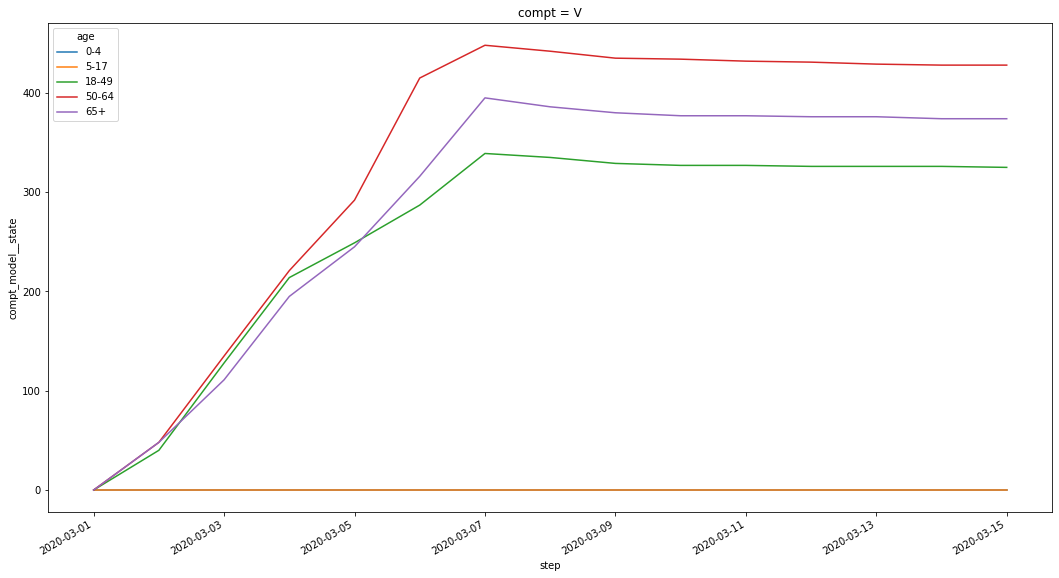

In [20]:
(age_model
 # we want to track the `state` variable from the `compt_model` process
 .out_ds['compt_model__state']
 # only looking at the V compartment
 .loc[dict(compt='V')]
 # sum over the other dimensions, leaving one `age` dimension
 .sum(['risk', 'vertex'])
 # plot over time
 .plot.line(x='step', aspect=2, size=9))

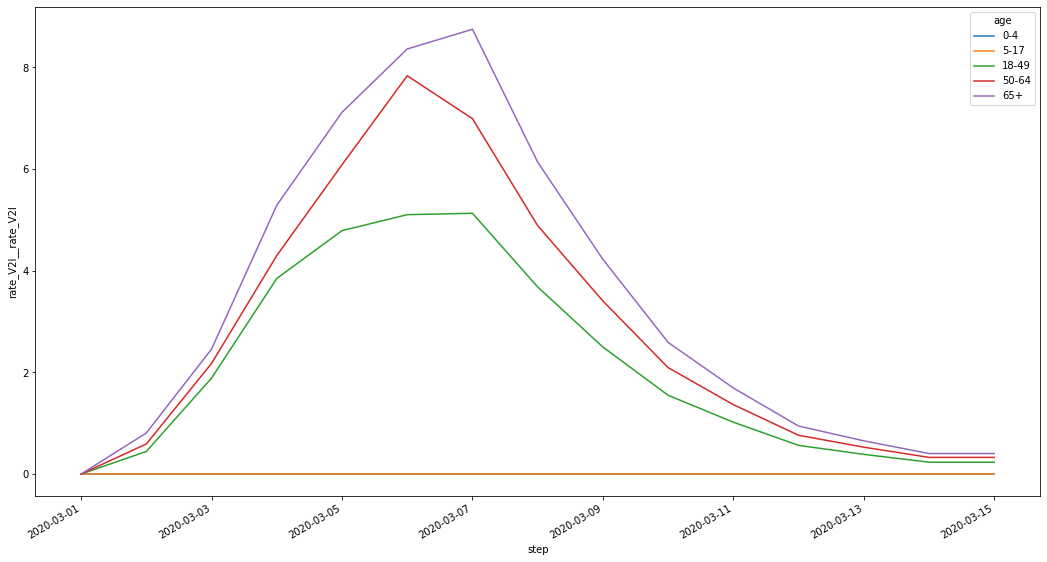

In [21]:
(age_model
 # we want to track the `rate_V2I` variable from the `rate_V2I` process
 .out_ds['rate_V2I__rate_V2I']
 # sum over the other dimensions, leaving one `age` dimension
 .sum(['risk', 'vertex'])
 # plot over time
 .plot.line(x='step', aspect=2, size=9))

## Package the Final Model
----

Now that we're finished with model development, we will package it into a model like `ExampleSIR` so that others can easily use it. This will involve writing a Python class (but not a "process") that contains:
- The model with its default processes. Most of the processes are the same as `ExampleSIR`
- Default parameter values
- Custom methods such as plotting

In short, we will package all of our work thus far into a standardized format that makes it easy to reproduce.

In [22]:
from episimlab.models import example_sir

In [23]:
class ExampleSIRV(EpiModel):
    # Optional: include some tags so that future users
    # could sort by model metadata
    TAGS = ('SIRV', 'compartments::4')
    
    # Define all the processes in this model
    PROCESSES = {
        # Core processes
        'compt_model': example_sir.ComptModel,
        'setup_sto': example_sir.SetupStochasticFromToggle,
        'setup_seed': example_sir.SeedGenerator,
        'setup_coords': example_sir.SetupCoords,
        'setup_state': example_sir.SetupState,
        'setup_phi': example_sir.SetupPhi,

        # Edge weight processes from ExampleSIR
        'rate_S2I': example_sir.FOI,
        'rate_I2R': example_sir.RecoveryRate,
        
        # Distinct from ExampleSIR
        'setup_compt_graph': CustomSetupComptGraph,
        'rate_S2V': AgeScaledRateS2V,
        'rate_V2I': RateV2I
    }
    
    # Define defaults that can be overwritten by user
    RUNNER_DEFAULTS = {
        'clocks': {
            'step': pd.date_range(start='3/1/2020', end='3/15/2020', freq='24H')
        },
        'input_vars': {
            'sto_toggle': 0, 
            'seed_entropy': 12345,
            'beta': 0.08,
            'gamma': 0.5,
            'vacc_efficacy': 0.9,
            'vacc_per_day': [0, 0, 5, 10, 10]
        },
        'output_vars': {
            'compt_model__state': 'step',
            'rate_V2I__rate_V2I': 'step'
        }
    }
    
    # Define custom plotting methods
    def plot(self):
        """Plot compartment populations over time."""
        return (self
                .out_ds['compt_model__state']
                .sum(['age', 'risk', 'vertex'])
                .plot.line(x='step', aspect=2, size=9)
        
    def plot_vacc(self):
        """Plot population of the vaccinated (V) compartment over time,
        stratified by age group.
        """
        return (self
                .out_ds['compt_model__state']
                .loc[dict(compt='V')]
                .sum(['risk', 'vertex'])
                .plot.line(x='step', aspect=2, size=9))
    
    def plot_rate_V2I(self):
        """Plot incident escape infections (`rate_V2I` over time),
        stratified by age group.
        """
        return (self
                .out_ds['rate_V2I__rate_V2I']
                .sum(['risk', 'vertex'])
                .plot.line(x='step', aspect=2, size=9))

Now, running our SIRV model is as easy as:

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.


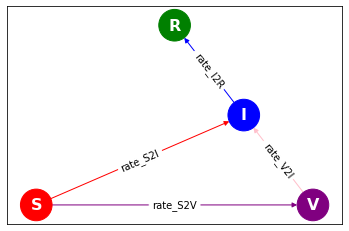

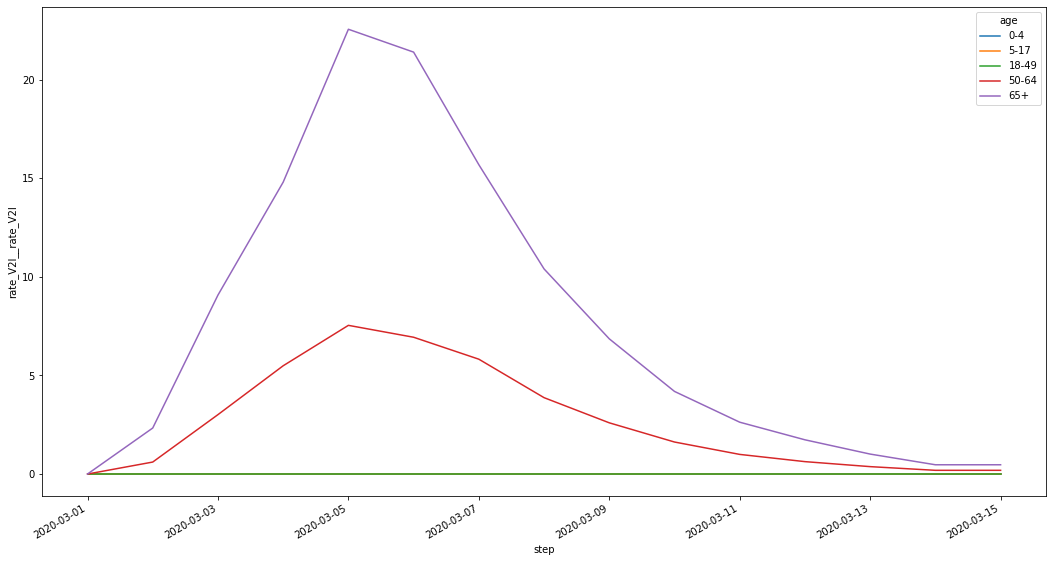

In [24]:
packaged_model = ExampleSIRV()
packaged_model.run(input_vars={
    # Optional: overwrite defaults
    'vacc_per_day': [0, 0, 0, 5, 20]
})
packaged_model.plot_rate_V2I()